### Assignment 12 : Term Project

Vidya Praveen

DSC530- Data Exploration and Analysis

Bellevue University

Spring 2023

### Data Set Overview
For the final project of __DSC530__, the used car dataset has been taken from Kaggle(https://www.kaggle.com/) 

  + The dataset contains details of the **used cars in germany** 
  + The dataset is not clean and hence a lot of data cleaning is carried out. For e.g. prices where too high which are      replaced by the median and outliers are removed accordingly. 
  + Also vehicles whose registration year was **_greater than 2016_ and _less than 1890_** were removed from the dataset as this data is inconsistense and would yield incorrect results.
  + As per project instruction, the initial data analysis and cleansing part has been kept minimal and EDA part has been more elaborative.

### 1. Initial setup

In [8]:
# importing required libraries
import os
import subprocess
import stat
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import thinkstats2
import thinkplot
from ydata_profiling import ProfileReport
from datetime import datetime
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
sns.set(style="white")

# ensuring graphs are displayed within same notebook, rather than new window
%matplotlib inline

ModuleNotFoundError: No module named 'thinkplot'

### 2. Data Ingestion

In [ ]:
# get absolute path till the raw data file
abs_path = os.getcwd()
data_path = "..\\data\\raw\\autos.csv"

# reading csv into raw dataframe
rawdf = pd.read_csv(data_path,encoding="latin-1")

### 3. Data Profiling

In [ ]:
# Create a data profile to plan data cleansing
ProfileReport(rawdf)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

The package in the previous step creates data profile and handles a lot of descriptive statistics like `mean`, `median`, `mode`, `quantile` and even correlation and distribuion. This takes a lot of individual steps away from the process.

The following _Data Cleansing_ section is largely driven by the data profile created already.

### 4. Data Cleansing

Remove irrelevant or duplicate data

In [ ]:
# Since there are 4 duplicate rows in the dataset, getting rid of the duplicates
df = rawdf.drop_duplicates().copy()

# dropping rows that are inconsistent with the dataset based on year of registration
df = df[df["yearOfRegistration"].between(1890, 2016, inclusive='both')]

# deleting the column noOfPictures since all of them are Zero
del df["nrOfPictures"]

Handle `null` or missing values

In [ ]:
# setting the NaN fuelType types to other
df["fuelType"].fillna("other",inplace=True)

# setting the NaN gearbox types to Unspecified
df["gearbox"].fillna("Unspecified", inplace=True)

# setting nan in model column to Other
df["model"].fillna("Other",inplace=True)

# setting nan in notRepairedDamage to other
df["notRepairedDamage"].fillna("other",inplace=True)

# changing the vehicleType from NaN to Others
df["vehicleType"].fillna("Other", inplace=True)

Handle language locale

In [ ]:
# Since the dataset is German, converting some of the German words in English

# changing values of offerType Gesuch to Request and Angebot to Offer
df["offerType"] = df["offerType"].map({'Gesuch':"Request",'Angebot':'Offer'})

# Changing german names to english readable format
df["fuelType"] = df["fuelType"].map({'benzin':'Gasoline','diesel':'Diesel','other':'Other','lpg':'Lpg','hybrid':'Hybrid','cng':'Cng','elektro':'Electric'})

# Changing german names to english readable format
df["notRepairedDamage"] = df["notRepairedDamage"].map({'other':'Other','ja':'Yes','nein':'No'})

Find the interquartile range for `vehicleType` and remove outliers.

In [ ]:
# Mean of the prices of all the vehicle types
_median = df.groupby("vehicleType")["price"].median()

# 75th percentile of the prices of all the vehicles types
_quantile75 = df.groupby("vehicleType")["price"].quantile(0.75)

# 25th percentile of the prices of all the vehicles types
_quantile25 = df.groupby("vehicleType")["price"].quantile(0.25)

# Calculating the value of the prices of each vehicle type above which all the values are outliers
iqr = (_quantile75 - _quantile25)*1.5 + _median
iqr

vehicleType
Other          3708.00
andere         8429.50
bus           13948.50
cabrio        21400.00
coupe         24300.00
kleinwagen     5775.00
kombi         13077.25
limousine     12801.50
suv           28800.00
Name: price, dtype: float64

In [ ]:
# Removing the outliers as per the logic above
df = df[((df["vehicleType"] == "andere") & (df["price"] <= 8429)) |
        ((df["vehicleType"] == "Other") & (df["price"] <= 3708)) |
        ((df["vehicleType"] == "suv") & (df["price"] <= 28800)) |
        ((df["vehicleType"] == "kombi") & (df["price"] <= 13076)) |
        ((df["vehicleType"] == "bus") & (df["price"] <= 13948)) |
        ((df["vehicleType"] == "cabrio") & (df["price"] <= 21400)) |
        ((df["vehicleType"] == "limousine") & (df["price"] <= 12801)) |
        ((df["vehicleType"] == "coupe") & (df["price"] <= 24300)) |
        ((df["vehicleType"] == "kleinwagen") & (df["price"] <= 5775))]

Handling dates

In [ ]:
# Create column for year of creation
df["yearOfCreation"] = df['dateCreated'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date().strftime('%Y'))

# Create column for year of crawling
df["yearCrawled"] = df['dateCrawled'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date().strftime('%Y'))

# Create column for month of creation
df["monthOfCreation"] = df['dateCreated'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date().strftime('%B'))

# Create column for month of crawling
df["monthCrawled"] = df['dateCrawled'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date().strftime('%B'))

# Create column for number of days seen online
from_date = df['dateCreated'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date())
to_date = df['lastSeen'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date())
no_days = abs((to_date-from_date))
no_days = (no_days / np.timedelta64(1, 'D')).astype(int)
df["NoOfDaysOnline"] = no_days

# Create column for number of hrs seen online
hrs_from = df['dateCreated'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').time().strftime('%H'))
hrs_to = df['lastSeen'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').time().strftime('%H'))
total_hrs = (hrs_to.astype(int) - hrs_from.astype(int))
df["NoOfHrsOnline"] = total_hrs

# Map the values on monthOfRegistration column from 1-12 
df["monthOfRegistration"].replace([0,12],[1,11],inplace=True)

# Calculate age of vehicle in years
df["yearsOld"] = 2016 - df["yearOfRegistration"]

# Calculate age of vehicle in months
df["monthsOld"] = 12 - df["monthOfRegistration"]

# Map the values on monthOfRegistration column from 1-12 to Jan to Dec
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov"]
df["monthOfRegistration"].replace([1,2,3,4,5,6,7,8,9,10,11],months,inplace=True)

Find correlation with price.

C:\Users\vidya\AppData\Local\Temp\ipykernel_12480\2388412512.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

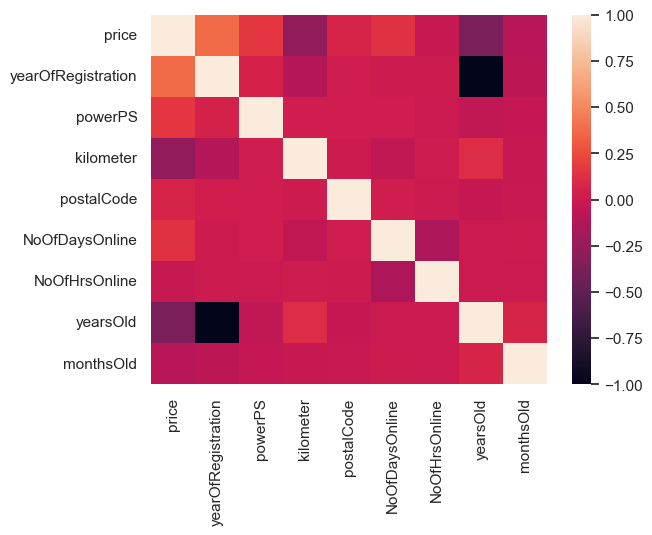

In [ ]:
corr = df.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

## Exploratory Data Analysis

### 1. Histograms

I chose the car price and 4 other features that have the strongest correlation in the above plot.

#### Price

Text(0.5, 1.0, 'Price')

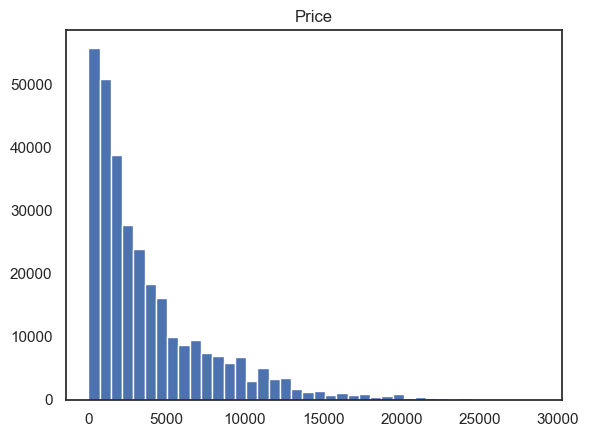

In [ ]:
plt.hist(df.price, bins=40)
plt.title("Price")

A lot of records has price as zero and very few has price greater than 20,000, with 28,800 being the most

#### Year of Registration

Text(0.5, 1.0, 'Year Of Registration')

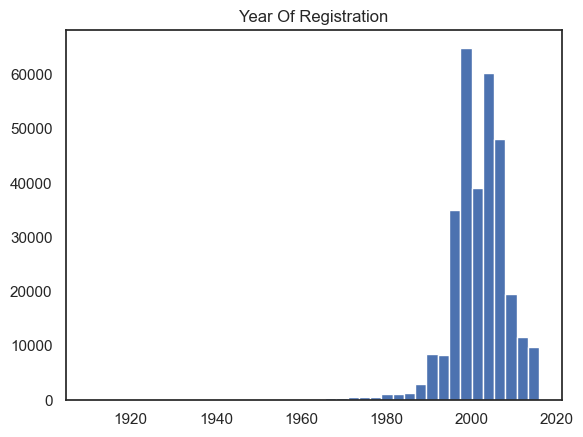

In [ ]:
plt.hist(df.yearOfRegistration, bins=40)
plt.title("Year Of Registration")

We can see that even after filtering the dataset between 1890 and 2016, we still have an outlier at 1910. Most of the listed cars are registered between 1990 and 2015.

#### Years Old

Text(0.5, 1.0, 'Years Old')

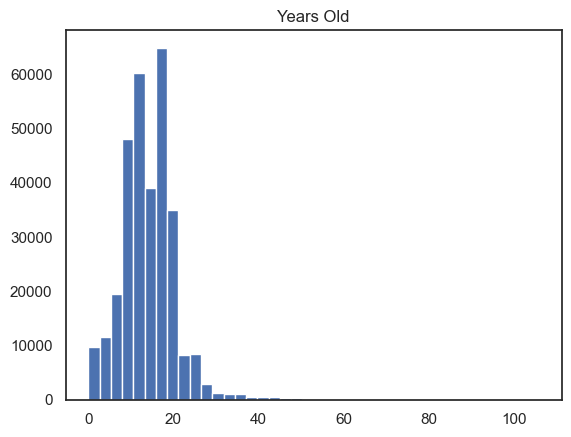

In [ ]:
plt.hist(df.yearsOld, bins=40)
plt.title("Years Old")

Most of the cars are between 10 to 20 years old, with an outlier of 106 years old car. 

#### Kilometer

Text(0.5, 1.0, 'Kilometer')

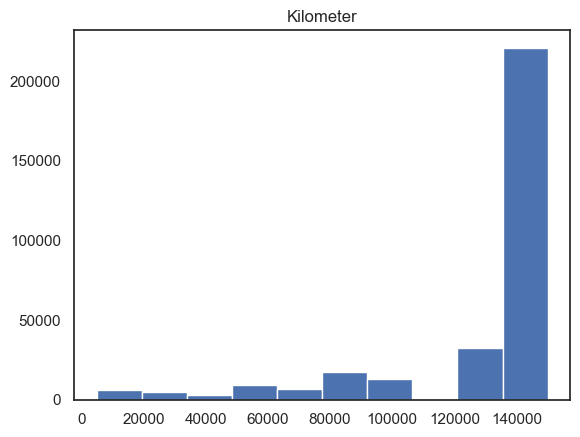

In [ ]:
plt.hist(df.kilometer, bins=10)
plt.title("Kilometer")

Since the data is of used cars, most of the cars have milleage acquired, but most of the cars have between 12,000 to 15,000 kilometer under the belt.

Text(0.5, 1.0, 'No Of Days Online')

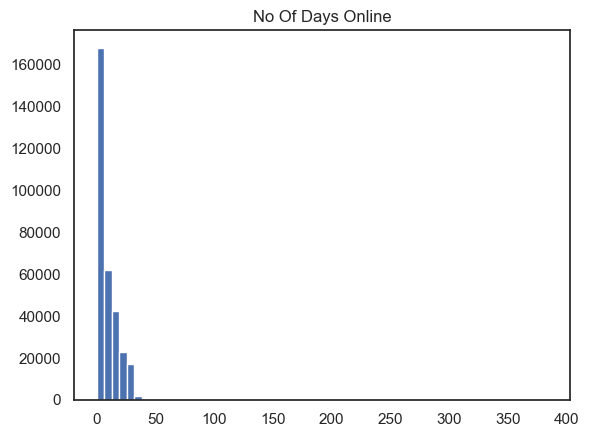

In [ ]:
plt.hist(df.NoOfDaysOnline, bins=60)
plt.title("No Of Days Online")

Majority of the cars came online very recently, under 10 days. But there is an outlier that has been online for 384 days.

### 2. Probability Mass Function (PMF)

I am going to divide the data set into two part, based on price. One part with price higher than the median value and another with price lower than the median value.

In [ ]:
medianprice = df.price.median()

df_highprice = df.price[df['price'] >= medianprice]
df_lowprice = df.price[df['price'] < medianprice]

df_lowprice = df_lowprice.astype(float)

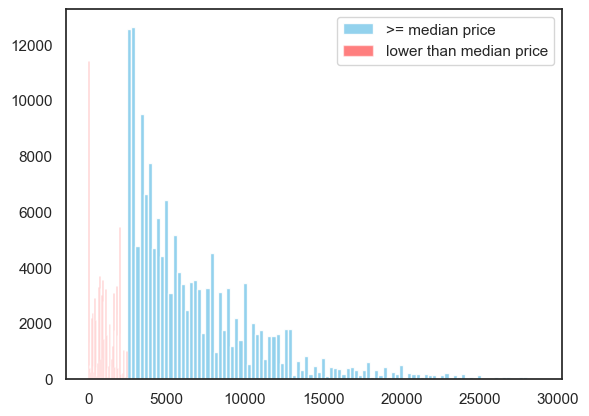

In [ ]:
bins = 100

plt.hist(df_highprice, bins, alpha=0.9, label='>= median price', color='skyblue')
plt.hist(df_lowprice, bins, alpha=0.5, label='lower than median price', color='red')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Another way
pmf = df_highprice.value_counts().sort_index() / len(df_highprice)
pmf.head()

2490    0.003443
2495    0.000108
2496    0.000013
2498    0.000038
2499    0.005878
Name: price, dtype: float64

Since _pmf_ is normalized, total probability would be __1__.

In [ ]:
pmf.sum()

1.0

In [ ]:
# Using the thinkstats2 module
thinkstats2.Pmf(df_highprice)

C:\Users\vidya\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())


Pmf({2500: 0.02705666343652777, 3500: 0.023288876421686134, 4500: 0.017920895598510737, 3000: 0.016448207272912737, 5500: 0.015026521140409038, 2800: 0.01327332075279237, 3200: 0.01288442903044831, 2900: 0.011526495639312491, 6500: 0.01137348906002958, 4000: 0.011296985770388127, 2999: 0.01107385117560055, 2600: 0.010423573213648188, 3900: 0.010213189167134188, 5000: 0.009951802927525883, 3800: 0.009735043606875096, 7500: 0.009696791962054368, 4200: 0.009499158463813944, 3300: 0.00944815627071964, 8500: 0.0093652777069414, 2700: 0.009288774417299944, 3999: 0.009001887081144489, 4900: 0.008612995358800429, 9500: 0.008211353088182792, 4999: 0.008115723976130975, 10500: 0.007714081705513337, 2950: 0.007682205334829398, 6000: 0.007637578415871883, 5900: 0.007369816902126792, 3600: 0.007261437241801397, 4800: 0.007114805936655276, 6900: 0.007076554291834549, 2750: 0.007019176824603458, 5200: 0.0068534196970469734, 12500: 0.006655786198806549, 3700: 0.006286020298872852, 3400: 0.006177640638

### 3. Cumulative Distribution Function (CDF)

I am using the _kilometer_ variable from the cars data to show how the kilometer reading of the cars is distributed across the data.

C:\Users\vidya\thinkstats2.py:162: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())


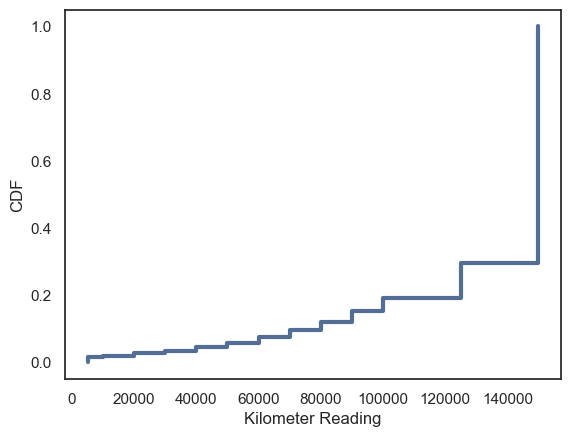

<Figure size 800x600 with 0 Axes>

In [ ]:
cdf = thinkstats2.Cdf(df.kilometer)
thinkplot.Cdf(cdf)
thinkplot.Show(xlabel='Kilometer Reading', ylabel='CDF', legend=False)

It looks like about 20% cars has run under 100000 kilometer, and about 30% cars has run under 120000 kilometer. This could be validated from the histogram of kilometer plotted earlier where we can see that the majority of cars fall under the ">120000" category. 
Common values appear as steep or vertical sections of the CDF; there are fewer values below 100000 kilometer, so the CDF in this range is flatter.

### 4. Analytical Distribution

For this, I am generating the normal probability plot for car price. It plots a gray line that represents the model and a blue line that represents the data.

In [ ]:
def MakeNormalPlot(weights):
    mean = weights.mean()
    std = weights.std()
    xs = -2, 2
    fxs, fys = thinkstats2.FitLine(xs, inter=mean, slope=std)
    thinkplot.Plot(fxs, fys, color='gray', label='model')
    xs,ys = thinkstats2.NormalProbability(weights)
    thinkplot.Plot(xs,ys, label='Model')

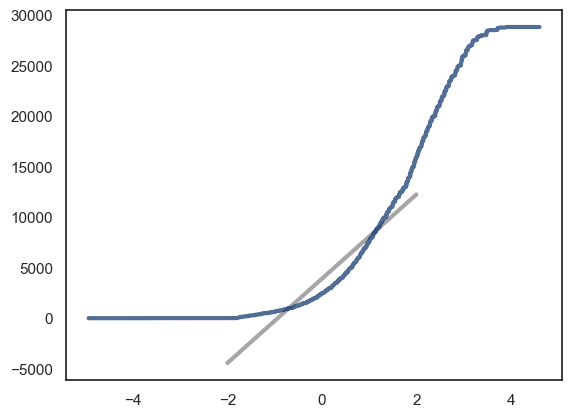

In [ ]:
MakeNormalPlot(df.price)

The data is closer to the model near the mean but deviates at the ends, meaning the expensive cars are more expensive than predicted. The data does not have any negative values as predicted by the model.

### 5. Scatter Plots

#### 1. Examining relationship between car price and the power of the car in PS. 

Excluding low powerPS values

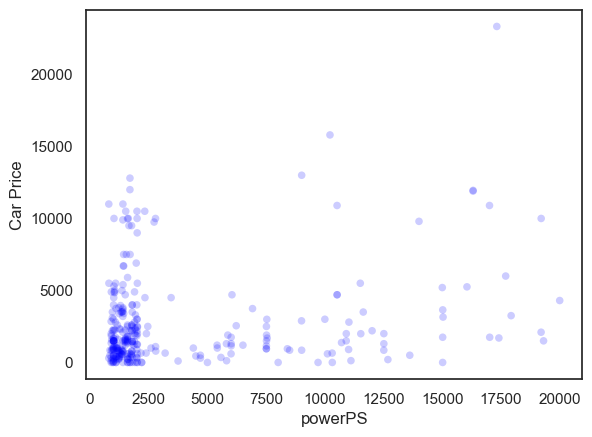

<Figure size 800x600 with 0 Axes>

In [ ]:
thinkplot.Scatter(df.powerPS[df['powerPS'] >= 800], df.price[df['powerPS'] >= 800])
thinkplot.Show(xlabel='powerPS', ylabel='Car Price')

In [ ]:
# Pearson coeficient
pearsonr(df.powerPS[df['powerPS'] >= 800], df.price[df['powerPS'] >= 800])

PearsonRResult(statistic=0.21656835484455628, pvalue=0.00016479332552372003)

From the plot and the coefficient, looks like powerPS and Car price has a weak positive correlation.

#### 2. Examining relationship between car's age and price

Excluding newer cars since their price is expected to be higher.

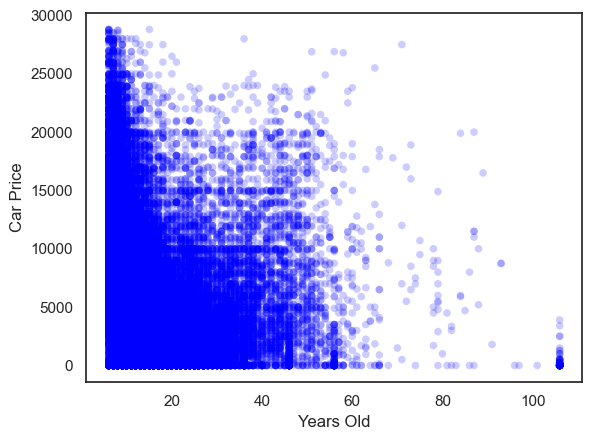

<Figure size 800x600 with 0 Axes>

In [ ]:
thinkplot.Scatter(df.yearsOld[df['yearsOld'] >= 6], df.price[df['yearsOld'] >= 6])
thinkplot.Show(xlabel='Years Old', ylabel='Car Price')

In [ ]:
# Pearson coeficient
pearsonr(df.yearsOld[df['yearsOld'] >= 6], df.price[df['yearsOld'] >= 6])

PearsonRResult(statistic=-0.37794879391483155, pvalue=0.0)

Car price has a declining relationship with the age of the car. From the data, we can say that the age is one of the factors that causes the price to change. We can see some outliers for cars older than 35 years who has high price.

### 6. Hypothesis Testing

Test correlation.

In [ ]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [ ]:
# Section data off into only the two columns that we want to test
data = df.price.values, df.kilometer.values

ht = CorrelationPermute(data)
ht.PValue()

0.0

_p-value_ of 0 indicates a failure to reject the null hypothesis at the 5% significance level.

### 7. Regression Analysis

Regression Analysis of one dependent and multiple explanatory variables.

In [ ]:
y = df['price'] #value we are predicting
x = df[['kilometer', 'powerPS', 'yearsOld', 'NoOfDaysOnline']] #explanatory variables

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.20, random_state=0) #split the data 80/20

model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [ ]:
coeff_df = pd.DataFrame(model.coef_, x.columns, columns=['Coefficient'])  
coeff_df 

Coefficient
kilometer         -0.027061
powerPS            3.450394
yearsOld        -209.161668
NoOfDaysOnline    58.250152

The _regression coefficient_ is the constant that represents the rate of change of one variable (price) as a function of changes in the others (kilometer, powerPS, yearsOld, NoOfDaysOnline); it is the slope of the regression line. In this case, Each coefficient estimates the change in the mean response per unit increase in price when all other predictors are held constant.

__** End of Code **__